# Ranking features with XGBoost

In [572]:
import xgboost
from xgboost import XGBRegressor, XGBClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from category_encoders import MEstimateEncoder, TargetEncoder
from sklearn.inspection import permutation_importance

import seaborn as sns
import shap


## Exploration of Data

In [573]:
df = pd.read_csv('Dataset/train.csv/train.csv')
print(df.shape)
print('-'*100)
print(df.info())
print('-'*100)
display(df.describe())
print('-'*100)
display(df.isnull().sum())

cols_with_na = df.columns[df.isna().any()].tolist()
print(f"Number of columns with NAN: {len(cols_with_na)}")


(30471, 292)
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 292 entries, id to price_doc
dtypes: float64(119), int64(157), object(16)
memory usage: 67.9+ MB
None
----------------------------------------------------------------------------------------------------


,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
count,30471.000000,30471.000000,24088.000000,30304.000000,20899.000000,20899.000000,1.686600e+04,20899.000000,20899.000000,16912.000000,...,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,3.047100e+04
mean,15237.917397,54.214269,34.403271,7.670803,12.558974,1.827121,3.068057e+03,1.909804,6.399301,2.107025,...,32.058318,10.783860,1.771783,15.045552,30.251518,0.442421,8.648814,52.796593,5.987070,7.123035e+06
std,8796.501536,38.031487,52.285733,5.319989,6.756550,1.481154,1.543878e+05,0.851805,28.265979,0.880148,...,73.465611,28.385679,5.418807,29.118668,47.347938,0.609269,20.580741,46.292660,4.889219,4.780111e+06
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05
25%,7620.500000,38.000000,20.000000,3.000000,9.000000,1.000000,1.967000e+03,1.000000,1.000000,1.000000,...,2.000000,1.000000,0.000000,2.000000,9.000000,0.000000,0.000000,11.000000,1.000000,4.740002e+06
50%,15238.000000,49.000000,30.000000,6.500000,12.000000,1.000000,1.979000e+03,2.000000,6.000000,2.000000,...,8.000000,2.000000,0.000000,7.000000,16.000000,0.000000,2.000000,48.000000,5.000000,6.274411e+06
75%,22855.500000,63.000000,43.000000,11.000000,17.000000,2.000000,2.005000e+03,2.000000,9.000000,3.000000,...,21.000000,5.000000,1.000000,12.000000,28.000000,1.000000,7.000000,76.000000,10.000000,8.300000e+06
max,30473.000000,5326.000000,7478.000000,77.000000,117.000000,6.000000,2.005201e+07,19.000000,2014.000000,33.000000,...,377.000000,147.000000,30.000000,151.000000,250.000000,2.000000,106.000000,218.000000,21.000000,1.111111e+08


----------------------------------------------------------------------------------------------------


id                       0
timestamp                0
full_sq                  0
life_sq               6383
floor                  167
                      ... 
mosque_count_5000        0
leisure_count_5000       0
sport_count_5000         0
market_count_5000        0
price_doc                0
Length: 292, dtype: int64

Number of columns with NAN: 51


In [574]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month

df.drop(['timestamp'], axis=1, inplace=True)

### Handpicked categorical features

In [575]:
categorical_cols = [
'id',
# 'timestamp',
'month',
'year',
'floor',
'material',
'max_floor',
'build_year',
'state',
'product_type',
'sub_area',
'ID_railroad_station_walk',
'ID_railroad_station_avto',
'water_1line',
'ID_big_road1',
'big_road1_1line',
'ID_big_road2',
'railroad_1line',
'ID_railroad_terminal',
'ID_bus_terminal',
'ecology',
'nuclear_reactor_raion',
'culture_objects_top_25',
'thermal_power_plant_raion',
'incineration_raion',
'oil_chemistry_raion',
'radiation_raion',
'railroad_terminal_raion',
'big_market_raion',
'nuclear_reactor_raion',
'detention_facility_raion',
'ID_metro',
]

# one hot
one_hot_cols = [
    'product_type',
]

# Target Encoding
target_encoding_cols = [
    'sub_area',
]

# label encoding
ordinal_cols = [
'ecology',
'floor',
'culture_objects_top_25',
'thermal_power_plant_raion',
'incineration_raion',
'oil_chemistry_raion',
'radiation_raion',
'railroad_terminal_raion',
'big_market_raion',
'nuclear_reactor_raion',
'detention_facility_raion',
'water_1line',
'big_road1_1line',
'railroad_1line',
'month',
# 'year',
'material',
'max_floor',
# 'build_year',
'state',
]



useless_cols = [
'id',
# 'timestamp',
# 'floor',
# 'material',
# 'max_floor',
# 'build_year',
# 'state',
# 'product_type',
# 'sub_area',
'ID_railroad_station_walk',
'ID_railroad_station_avto',
# 'water_1line',
'ID_big_road1',
# 'big_road1_1line',
'ID_big_road2',
# 'railroad_1line',
'ID_railroad_terminal',
'ID_bus_terminal',
# 'ecology',
# 'nuclear_reactor_raion',
# 'culture_objects_top_25',
# 'thermal_power_plant_raion',
# 'incineration_raion',
# 'oil_chemistry_raion',
# 'radiation_raion',
# 'railroad_terminal_raion',
# 'big_market_raion',
# 'nuclear_reactor_raion',
# 'detention_facility_raion',
'ID_metro',

]


numeric_cols =[
'full_sq',
'life_sq',
'num_room',
'kitch_sq',
'area_m',
'raion_popul',
'green_zone_part',
'indust_part',
'children_preschool',
'preschool_quota',
'preschool_education_centers_raion',
'children_school',
'school_quota',
'school_education_centers_raion',
'school_education_centers_top_20_raion',
'hospital_beds_raion',
'healthcare_centers_raion',
'university_top_20_raion',
'sport_objects_raion',
'additional_education_raion',
'culture_objects_top_25_raion',
'shopping_centers_raion',
'office_raion',
'full_all',
'male_f',
'female_f',
'young_all',
'young_male',
'young_female',
'work_all',
'work_male',
'work_female',
'ekder_all',
'ekder_male',
'ekder_female',
'0_6_all',
'0_6_male',
'0_6_female',
'7_14_all',
'7_14_male',
'7_14_female',
'0_17_all',
'0_17_male',
'0_17_female',
'16_29_all',
'16_29_male',
'16_29_female',
'0_13_all',
'0_13_male',
'0_13_female',
'raion_build_count_with_material_info',
'build_count_block',
'build_count_wood',
'build_count_frame',
'build_count_brick',
'build_count_monolith',
'build_count_panel',
'build_count_foam',
'build_count_slag',
'build_count_mix',
'raion_build_count_with_builddate_info',
'build_count_before_1920',
'build_count_1921-1945',
'build_count_1946-1970',
'build_count_1971-1995',
'build_count_after_1995',
'metro_min_avto',
'metro_km_avto',
'metro_min_walk',
'metro_km_walk',
'kindergarten_km',
'school_km',
'park_km',
'green_zone_km',
'industrial_km',
'water_treatment_km',
'cemetery_km',
'incineration_km',
'railroad_station_walk_km',
'railroad_station_walk_min',
'railroad_station_avto_km',
'railroad_station_avto_min',
'public_transport_station_km',
'public_transport_station_min_walk',
'water_km',
'mkad_km',
'ttk_km',
'sadovoe_km',
'bulvar_ring_km',
'kremlin_km',
'big_road1_km',
'big_road2_km',
'railroad_km',
'zd_vokzaly_avto_km',
'bus_terminal_avto_km',
'oil_chemistry_km',
'nuclear_reactor_km',
'radiation_km',
'power_transmission_line_km',
'thermal_power_plant_km',
'ts_km',
'big_market_km',
'market_shop_km',
'fitness_km',
'swim_pool_km',
'ice_rink_km',
'stadium_km',
'basketball_km',
'hospice_morgue_km',
'detention_facility_km',
'public_healthcare_km',
'university_km',
'workplaces_km',
'shopping_centers_km',
'office_km',
'additional_education_km',
'preschool_km',
'big_church_km',
'church_synagogue_km',
'mosque_km',
'theater_km',
'museum_km',
'exhibition_km',
'catering_km',
'green_part_500',
'prom_part_500',
'office_count_500',
'office_sqm_500',
'trc_count_500',
'trc_sqm_500',
'cafe_count_500',
'cafe_sum_500_min_price_avg',
'cafe_sum_500_max_price_avg',
'cafe_avg_price_500',
'cafe_count_500_na_price',
'cafe_count_500_price_500',
'cafe_count_500_price_1000',
'cafe_count_500_price_1500',
'cafe_count_500_price_2500',
'cafe_count_500_price_4000',
'cafe_count_500_price_high',
'big_church_count_500',
'church_count_500',
'mosque_count_500',
'leisure_count_500',
'sport_count_500',
'market_count_500',
'green_part_1000',
'prom_part_1000',
'office_count_1000',
'office_sqm_1000',
'trc_count_1000',
'trc_sqm_1000',
'cafe_count_1000',
'cafe_sum_1000_min_price_avg',
'cafe_sum_1000_max_price_avg',
'cafe_avg_price_1000',
'cafe_count_1000_na_price',
'cafe_count_1000_price_500',
'cafe_count_1000_price_1000',
'cafe_count_1000_price_1500',
'cafe_count_1000_price_2500',
'cafe_count_1000_price_4000',
'cafe_count_1000_price_high',
'big_church_count_1000',
'church_count_1000',
'mosque_count_1000',
'leisure_count_1000',
'sport_count_1000',
'market_count_1000',
'green_part_1500',
'prom_part_1500',
'office_count_1500',
'office_sqm_1500',
'trc_count_1500',
'trc_sqm_1500',
'cafe_count_1500',
'cafe_sum_1500_min_price_avg',
'cafe_sum_1500_max_price_avg',
'cafe_avg_price_1500',
'cafe_count_1500_na_price',
'cafe_count_1500_price_500',
'cafe_count_1500_price_1000',
'cafe_count_1500_price_1500',
'cafe_count_1500_price_2500',
'cafe_count_1500_price_4000',
'cafe_count_1500_price_high',
'big_church_count_1500',
'church_count_1500',
'mosque_count_1500',
'leisure_count_1500',
'sport_count_1500',
'market_count_1500',
'green_part_2000',
'prom_part_2000',
'office_count_2000',
'office_sqm_2000',
'trc_count_2000',
'trc_sqm_2000',
'cafe_count_2000',
'cafe_sum_2000_min_price_avg',
'cafe_sum_2000_max_price_avg',
'cafe_avg_price_2000',
'cafe_count_2000_na_price',
'cafe_count_2000_price_500',
'cafe_count_2000_price_1000',
'cafe_count_2000_price_1500',
'cafe_count_2000_price_2500',
'cafe_count_2000_price_4000',
'cafe_count_2000_price_high',
'big_church_count_2000',
'church_count_2000',
'mosque_count_2000',
'leisure_count_2000',
'sport_count_2000',
'market_count_2000',
'green_part_3000',
'prom_part_3000',
'office_count_3000',
'office_sqm_3000',
'trc_count_3000',
'trc_sqm_3000',
'cafe_count_3000',
'cafe_sum_3000_min_price_avg',
'cafe_sum_3000_max_price_avg',
'cafe_avg_price_3000',
'cafe_count_3000_na_price',
'cafe_count_3000_price_500',
'cafe_count_3000_price_1000',
'cafe_count_3000_price_1500',
'cafe_count_3000_price_2500',
'cafe_count_3000_price_4000',
'cafe_count_3000_price_high',
'big_church_count_3000',
'church_count_3000',
'mosque_count_3000',
'leisure_count_3000',
'sport_count_3000',
'market_count_3000',
'green_part_5000',
'prom_part_5000',
'office_count_5000',
'office_sqm_5000',
'trc_count_5000',
'trc_sqm_5000',
'cafe_count_5000',
'cafe_sum_5000_min_price_avg',
'cafe_sum_5000_max_price_avg',
'cafe_avg_price_5000',
'cafe_count_5000_na_price',
'cafe_count_5000_price_500',
'cafe_count_5000_price_1000',
'cafe_count_5000_price_1500',
'cafe_count_5000_price_2500',
'cafe_count_5000_price_4000',
'cafe_count_5000_price_high',
'big_church_count_5000',
'church_count_5000',
'mosque_count_5000',
'leisure_count_5000',
'sport_count_5000',
'market_count_5000',
'price_doc',    
]



In [576]:
for c in categorical_cols:
    df[c] = df[c].astype('category')

In [577]:
cafe_list = []
for p in df.select_dtypes(include='number').columns:
    if 'cafe' in p:
        cafe_list.append(p)

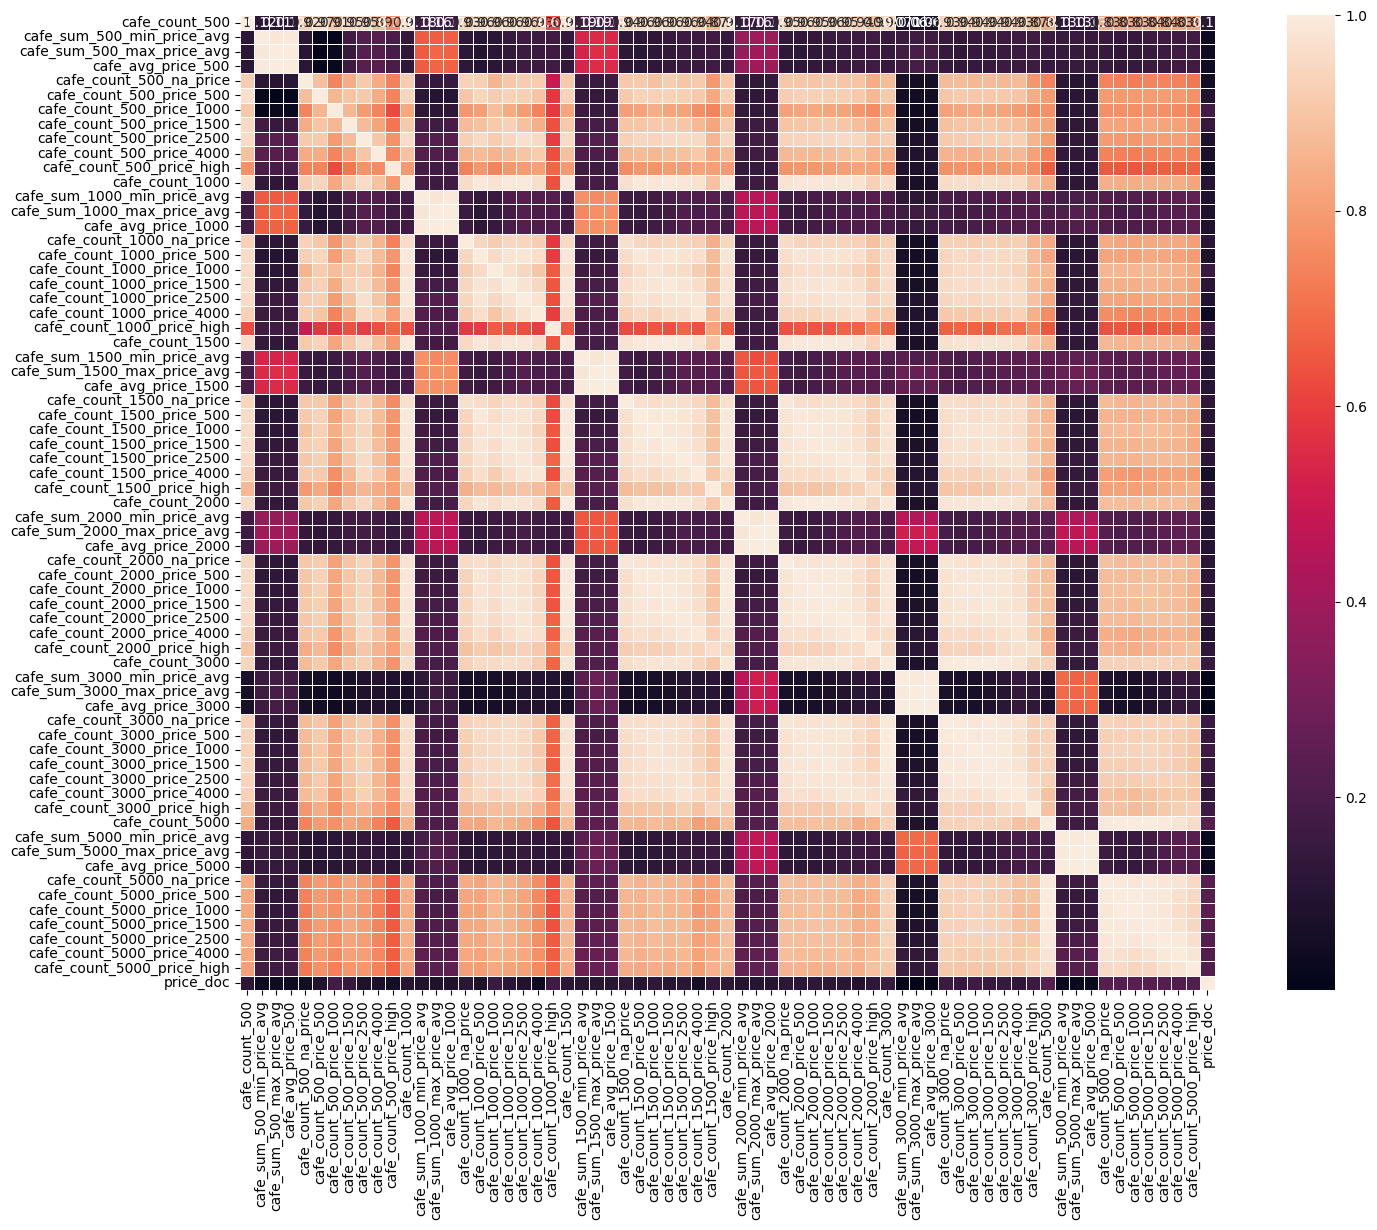

In [578]:
corrmat = df[cafe_list + ['price_doc']].corr()

plt.subplots(figsize=(18, 15))
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)
plt.subplots_adjust(top = 0.95, bottom = 0.3, left = 0.2, right = 1)
plt.show()

In [579]:
# Break down of one-hot cols
for c in one_hot_cols:
    print(f"Number of unique values for {c}: {df[c].nunique()}")
    display(df[c].value_counts().head(20))

Number of unique values for product_type: 2


product_type
Investment       19448
OwnerOccupier    11023
Name: count, dtype: int64

## Pre-processing

In [580]:
# Replacing NAN with mean
df2 = df.copy()
# useless_cols += cafe_list
df2.drop(useless_cols, axis=1, inplace=True)


In [581]:
for c in cols_with_na:
    if c not in useless_cols and df2[c].dtype.name != 'category':
        df2[c] = df2[c].fillna((df2[c].mean()))

print("Columns with NAN after update: ")
df2.columns[df2.isna().any()].tolist()

Columns with NAN after update: 


['floor', 'max_floor', 'material', 'build_year', 'state']

### One-hot Encoding

In [582]:
# One Hot Encoding
df2 = pd.get_dummies(df2, columns=one_hot_cols, dtype='int64')
df2.head()


,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,...,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,year,month,product_type_Investment,product_type_OwnerOccupier
0,43,27.0,4.0,NaN,NaN,NaN,1.909804,6.399301,NaN,Bibirevo,...,22,1,0,52,4,5850000,2011,8,1,0
1,34,19.0,3.0,NaN,NaN,NaN,1.909804,6.399301,NaN,Nagatinskij Zaton,...,29,1,10,66,14,6000000,2011,8,1,0
2,43,29.0,2.0,NaN,NaN,NaN,1.909804,6.399301,NaN,Tekstil'shhiki,...,27,0,4,67,10,5700000,2011,8,1,0
3,89,50.0,9.0,NaN,NaN,NaN,1.909804,6.399301,NaN,Mitino,...,4,0,0,26,3,13100000,2011,9,1,0
4,77,77.0,4.0,NaN,NaN,NaN,1.909804,6.399301,NaN,Basmannoe,...,236,2,91,195,14,16331452,2011,9,1,0


### Ordinal Encoding
For ordinal values

In [583]:
# Label encoding
oe = OrdinalEncoder()
oe.fit(df2[ordinal_cols])
df2[ordinal_cols] = oe.transform(df2[ordinal_cols])

df2[ordinal_cols].head()



,ecology,floor,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,month,material,max_floor,state
0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,NaN,NaN,NaN
1,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,NaN,NaN,NaN
2,3.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,NaN,NaN,NaN
3,1.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,NaN,NaN,NaN
4,0.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,NaN,NaN,NaN


In [584]:
df2.select_dtypes(include='category').columns
df2.dropna(subset=['build_year'], inplace=True)

print("Columns with NAN after update: ", df2.columns[df2.isna().any()].tolist())
print("Num NANs: ", df2.isnull().sum().sum())


print("Droppping NANs")
df2.dropna(inplace=True)

df2.shape


Columns with NAN after update:  ['state']
Num NANs:  1600
Droppping NANs


(15266, 286)

In [585]:
print("converting years to int")
df2[['year', 'build_year']] = df2[['year', 'build_year']].astype('int64')
df2.select_dtypes(exclude='number').columns

converting years to int


Index(['sub_area'], dtype='object')

### Target Encoding for sub_area
Due to the many different values, target encoding is more approriate. We will first split the dataset into train and test.

#### Split Dataset

In [587]:
y = df2['price_doc']
X = df2.copy()

display(y.head())
display(X.head())

8056    2750000
8135    9000000
8153    7011550
8154    7100000
8186    5903808
Name: price_doc, dtype: int64

,full_sq,life_sq,floor,max_floor,material,num_room,kitch_sq,state,sub_area,area_m,...,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,product_type_Investment,product_type_OwnerOccupier
8056,11,11.000000,2.0,5.0,1.0,1.0,12.0,2.0,Hamovniki,1.007156e+07,...,26,133,207,1,89,161,10,2750000,1,0
8135,53,30.000000,10.0,16.0,0.0,2.0,8.0,2.0,Lianozovo,5.646405e+06,...,0,11,21,1,0,46,5,9000000,1,0
8153,77,41.000000,2.0,17.0,5.0,3.0,12.0,0.0,Poselenie Voskresenskoe,2.149409e+07,...,0,1,7,1,0,12,1,7011550,0,1
8154,45,27.000000,6.0,9.0,0.0,2.0,6.0,2.0,Severnoe Butovo,8.889467e+06,...,0,3,8,1,0,19,3,7100000,1,0
8186,63,34.403271,17.0,17.0,3.0,2.0,1.0,0.0,Nekrasovka,1.139168e+07,...,0,2,3,0,0,6,1,5903808,0,1


In [588]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

- Testing with M Estimate Encoding
- Create the encoder instance. Choose m to control noise.

In [589]:
# m_encoder = MEstimateEncoder(cols=target_encoding_cols, m=10.0)

# # Fit the encoder on the encoding split.
# m_encoder.fit(X_train, y_train)

# # Encode the sub_area column to create the final training data
# X_train['sub_area_mestimate'] = m_encoder.transform(X_train)['sub_area']
# X_train[['sub_area_mestimate']].head()

# # Transform test data
# X_test['sub_area_mestimate'] = m_encoder.transform(X_test)['sub_area']


# plt.figure(dpi=90)
# ax = sns.distplot(y, kde=False, norm_hist=True)
# ax = sns.kdeplot(X_train['sub_area_mestimate'], color='r', ax=ax)
# ax.set_xlabel("price_doc")
# ax.legend(labels=['sub_area_mestimate', 'price_doc'])

- Testing with Target Encoding
- Smoothing = Regularization --> Making sth less complex --> prevent overfitting
- 'min_samples_leaf' is the minimum number of samples within a category to take it's mean into account.


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a fig

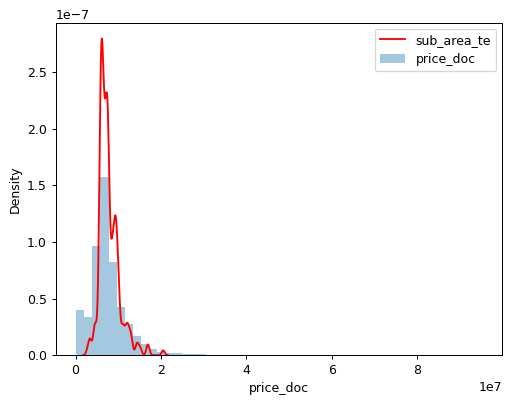

In [590]:
te_encoder = TargetEncoder(cols=target_encoding_cols, min_samples_leaf=5, smoothing=8)

# Fit the encoder on the encoding split.
te_encoder.fit(X_train, y_train)

# Encode the sub_area column to create the final training data
X_train['sub_area_te'] = te_encoder.transform(X_train)['sub_area']
X_train[['sub_area_te']].head()

# Transform test data
X_test['sub_area_te'] = te_encoder.transform(X_test)['sub_area']

plt.figure(dpi=90)
ax = sns.distplot(y, kde=False, norm_hist=True)
ax = sns.kdeplot(X_train['sub_area_te'], color='r', ax=ax)
ax.set_xlabel("price_doc")
ax.legend(labels=['sub_area_te', 'price_doc'])

In [591]:
# Drop 'sub_area'
X_train.drop(['sub_area', 'price_doc'], axis=1, inplace=True)
X_test.drop(['sub_area', 'price_doc'], axis=1, inplace=True)

In [592]:
print(X_train.info())

print(X_train.shape)


<class 'pandas.core.frame.DataFrame'>
Index: 11449 entries, 30029 to 25856
Columns: 282 entries, full_sq to sub_area_te
dtypes: float64(131), int64(151)
memory usage: 24.7 MB
None
(11449, 282)


No more cat data type!

### Testing

In [593]:
# Convert to DMatrix
train_data = xgboost.DMatrix(X_train, label=y_train)
test_data = xgboost.DMatrix(X_test, label=y_test)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

In [594]:
params = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist',
}

In [595]:
n = 100
model = xgboost.train(
    params=params,
    dtrain=train_data,
    num_boost_round=n,
    )

[13:53:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



In [596]:
pred = model.predict(test_data)

[13:53:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



In [597]:
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)

print(f"RMSE: {rmse}")
print(f"R2: {r2}")


RMSE: 2881124.7163237594
R2: 0.6808108599668621


- Weight. The number of times a feature is used to split the data across all trees.
- Cover. The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.
- Gain. The average training loss reduction gained when using a feature for splitting.  [*MOST IMPORTANT*]

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

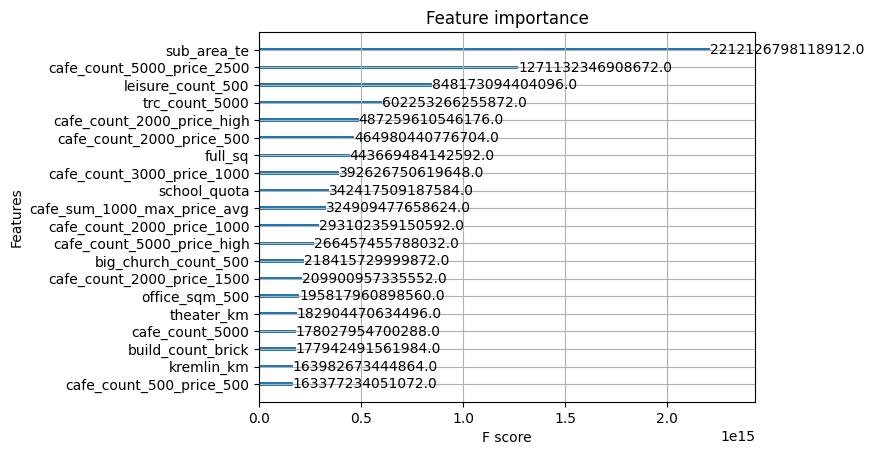

In [598]:
limit = 20
xgboost.plot_importance(model, importance_type='gain', max_num_features=limit)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

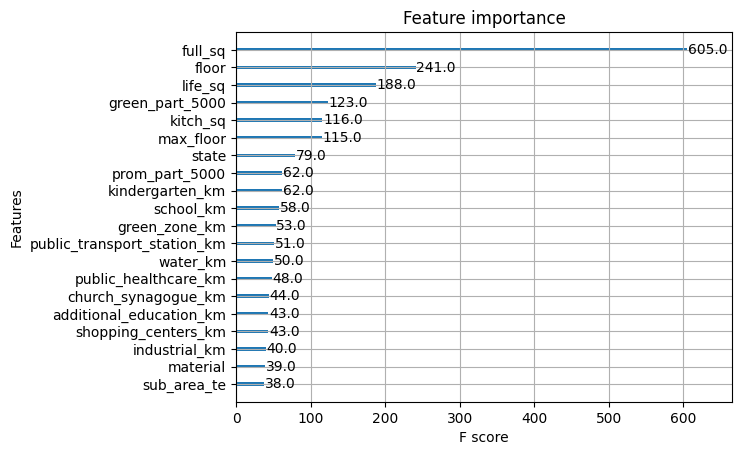

In [599]:
xgboost.plot_importance(model, importance_type='weight', max_num_features=limit)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

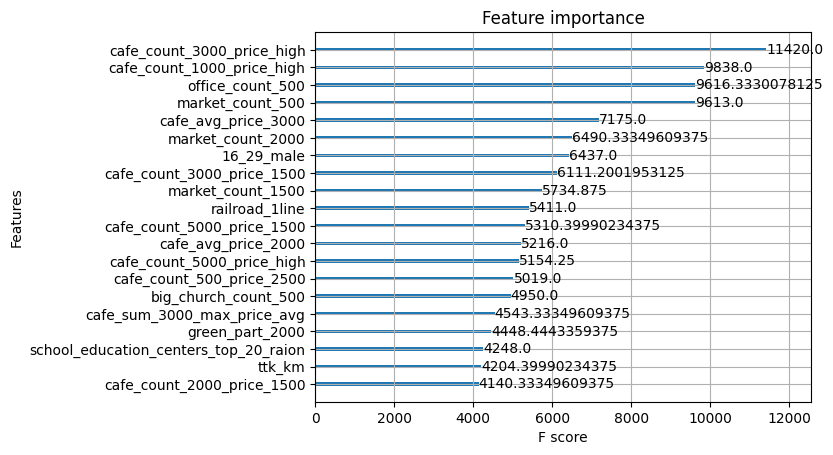

In [600]:
xgboost.plot_importance(model, importance_type='cover', max_num_features=limit)

In [601]:
params2 = {
    'n_estimators': 100,
    'device': 'cuda',
    # 'random_state': 24,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmsle',
    'enable_categorical': True,
    'eta': 0.1
}

In [602]:
model2 = XGBRegressor(n_estimaters=params2['n_estimators'],
                      device=params2['device'],
                    #   random_state=params2['random_state'],
                      objective=params2['objective'],
                      eval_metric=params2['eval_metric'],
                      enable_categorical=params2['enable_categorical'],
                      eta=params2['eta']
                      )

model2.fit(X_train, y_train)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
[13:53:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimaters" } are not used.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=True, eta=0.1, eval_metric='rmsle',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimaters=100,
             n_estimators=None, n_jobs=None, ...)

In [603]:
pred = model2.predict(X_test)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


In [604]:
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)

print(f"RMSE: {rmse}")
print(f"R2: {r2}")


RMSE: 2867375.255561525
R2: 0.6838500943228302


In [605]:
sorted_idx = model2.feature_importances_.argsort()[::-1]

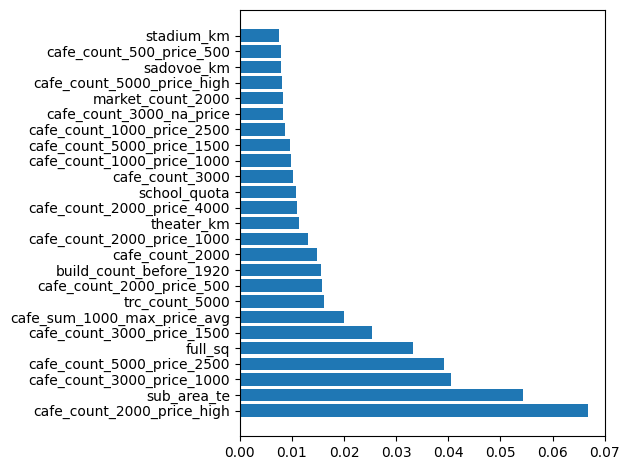

In [606]:
# limit = len(sorted_idx)
limit = 25
plt.barh(model2.feature_names_in_[sorted_idx[:limit]], model2.feature_importances_[sorted_idx[:limit]])
plt.tight_layout()

In [607]:
perm_importance = permutation_importance(model2, X_test, y_test)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated 

Text(0.5, 0, 'Permutation Importance')

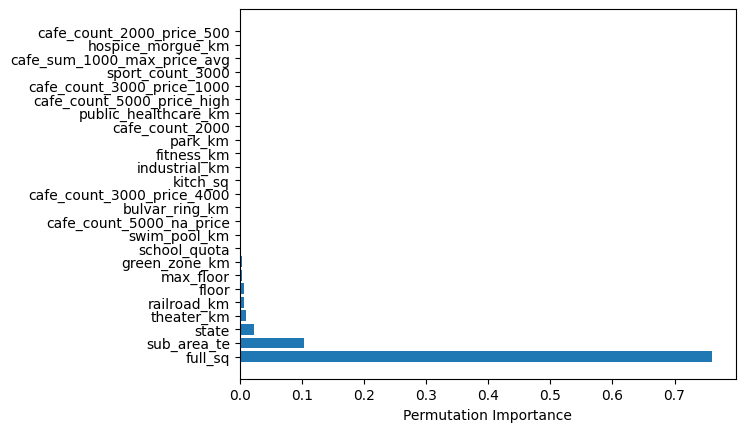

In [608]:
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

plt.barh(model2.feature_names_in_[sorted_idx[:limit]], perm_importance.importances_mean[sorted_idx[:limit]])
plt.xlabel("Permutation Importance")

In [609]:
explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(X_test)

[13:55:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


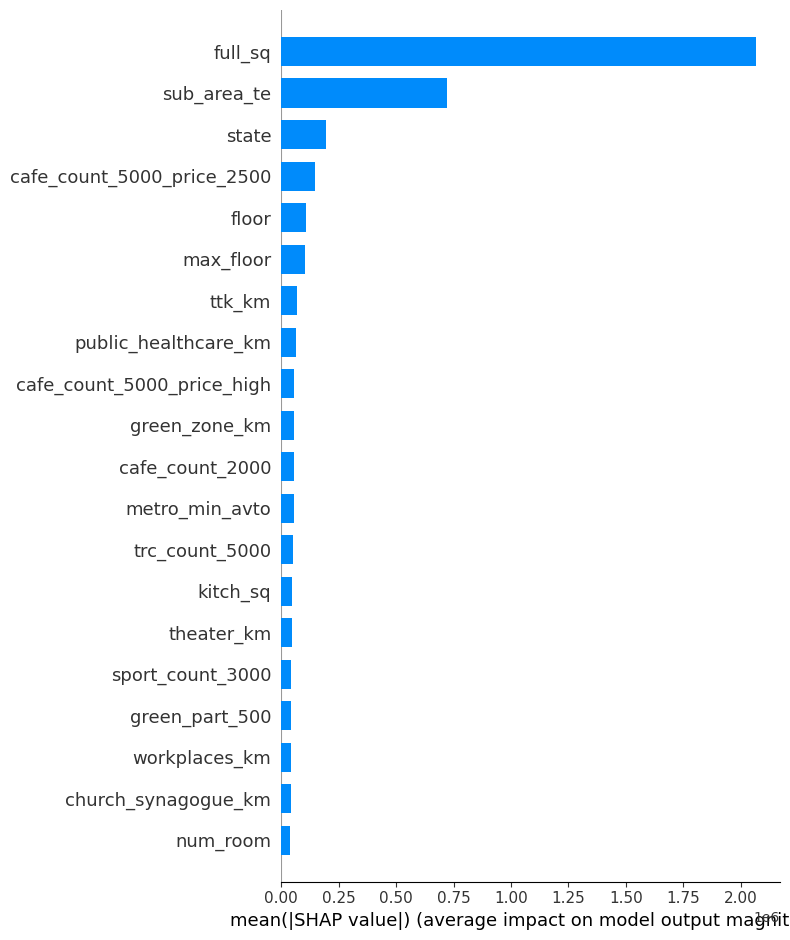

In [610]:
shap.summary_plot(shap_values, X_test, plot_type="bar")